## Downloading and combining all data, applying various algorithms for predictions
This notebook is used per cashtag to dowload its combined data of tweets and stock data, then applying each of the six binary classifiers to it. The result is an overview of the accuracy of the classifiers on each cashtag, using an 80/20 Train/Test split and 10-fold cross validation.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
import xlsxwriter
import os

### List all files in the folder

In [2]:
# import glob

# glob.glob("C:/Users/jangn/OneDrive/CODE/Stock_markets/Cashtags/*.xlsx")

#### The code snippet below will initialize a blank DataFrame then append all of the individual files into the all_data DataFrame. The resulting dataframe contains all the combined data created with the first notebook (Part 1) for each cashtag;  c. 6800 rows = 74 days * 92 companies. 
https://pbpython.com/excel-file-combine.html

In [3]:
# all_data = pd.DataFrame()
# for f in glob.glob("C:/Users/jangn/OneDrive/CODE/Stock_markets/Cashtags/*.xlsx"):
#     df = pd.read_excel(f)
#     all_data = all_data.append(df,ignore_index=True)

### Reading only one excel at a time
The binary classifiers are trained on each cashtag's twitter and stock data individually.

In [4]:
xls = pd.ExcelFile('C:/Users/jangn/OneDrive/CODE/Stock_markets/Cashtags/$AAL_minusones.xlsx') # Update cashtag; separate for each run.
all_data = pd.read_excel(xls, header = 0,encoding='latin-1')

### Remove the last row for each cashtag, since its 'Predicted_change' is  NaN

In [5]:
all_data = all_data[np.isfinite(all_data['Predicted_change_stock'])]
all_data = all_data[np.isfinite(all_data['Buy/Sell'])]

In [6]:
nan_rows = all_data[all_data['Predicted_change_stock'].isnull()]
nan_rows

,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,Favs,RTs,Followers,Following,Is a RT,compound,neg,neu,pos,Compound_multiplied,Compound_multiplied_scaled,Predicted_change_stock,Buy/Sell


In [7]:
len(all_data)

74

In [8]:
all_data.describe()

,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,Favs,RTs,Followers,Following,Is a RT,compound,neg,neu,pos,Compound_multiplied,Compound_multiplied_scaled,Predicted_change_stock,Buy/Sell
count,7.400000e+01,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,9.731227e+06,33.997063,2.866570,-0.447087,0.022178,1.873590,2.362778,4158.740790,1047.781398,0.136907,0.218461,0.055512,0.796866,0.147624,442.440350,0.022435,-0.488144,-0.243243
std,3.143877e+06,3.336924,0.999271,1.512450,0.860596,1.489856,1.779835,6194.575281,1178.949550,0.143181,0.130938,0.027647,0.036900,0.040814,3204.139740,0.091246,1.581633,0.976586
min,5.018200e+06,30.006098,1.373308,-5.089362,-2.619312,1.000000,1.000000,28.000000,11.000000,0.000000,-0.042245,0.000000,0.695500,0.063667,-24255.853656,-0.680912,-5.089362,-1.000000
25%,7.338450e+06,31.092009,2.060415,-1.211461,-0.412757,1.000000,1.000000,1367.875962,395.832358,0.034483,0.121496,0.038277,0.780541,0.126429,124.810639,0.013390,-1.211461,-1.000000
50%,9.032517e+06,32.221743,2.770293,-0.418915,0.038208,1.450000,2.305556,2583.105392,723.038462,0.099408,0.214772,0.056847,0.797208,0.137407,407.177512,0.021431,-0.418915,-1.000000
75%,1.160547e+07,37.443207,3.503908,0.482330,0.551023,1.968597,2.501522,4460.559091,1371.403125,0.200000,0.269424,0.073731,0.816801,0.161935,1124.456466,0.041857,0.482330,1.000000
max,2.093950e+07,40.145294,5.669799,3.565896,2.305596,10.666667,12.428571,37904.563380,8271.600000,0.600000,0.851300,0.139414,0.865750,0.304500,7057.999731,0.210830,3.565896,1.000000


In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74 entries, 2016-04-01 to 2016-06-13
Data columns (total 18 columns):
Volume_stock                  74 non-null float64
Adj_Close_stock               74 non-null float64
HiLo_vola_stock               74 non-null float64
Pct_change_stock              74 non-null float64
Pct_change_stock_scaled       74 non-null float64
Favs                          74 non-null float64
RTs                           74 non-null float64
Followers                     74 non-null float64
Following                     74 non-null float64
Is a RT                       74 non-null float64
compound                      74 non-null float64
neg                           74 non-null float64
neu                           74 non-null float64
pos                           74 non-null float64
Compound_multiplied           74 non-null float64
Compound_multiplied_scaled    74 non-null float64
Predicted_change_stock        74 non-null float64
Buy/Sell                   

### How are the 'Compound_multiplied_scaled' -features distributed

C:\Users\jangn\AppData\Local\Enthought\Canopy\edm\envs\Default_Python3\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


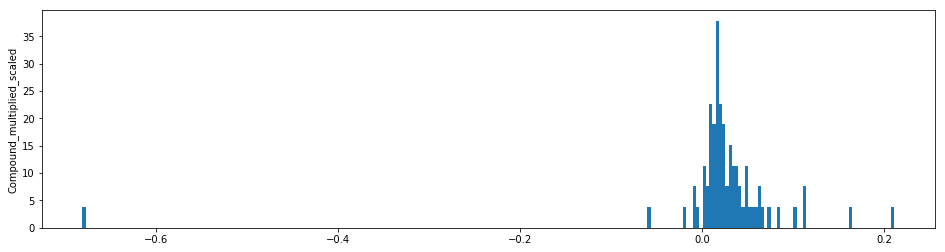

In [10]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0
x = all_data['Compound_multiplied_scaled'] 
plt.hist(x, normed=True, bins=250)
plt.ylabel('Compound_multiplied_scaled'); 


### Train - Test split

In [11]:
x = np.array(all_data[['Compound_multiplied_scaled']]) #
y = np.array(all_data['Buy/Sell'])

# from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

### KNN - K-Nearest-Neighbors
Accuracy from running only 20% Testing data against 80% Training data.

In [12]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train, y_train) 
neigh.score( x_test, y_test)

0.59999999999999998

#### Accuracy after cross validation 

In [13]:
neigh_cv = cross_val_score(neigh, x_train, y_train, cv=10) 
print(neigh_cv.mean()) 

0.575238095238


### Logistic Regression
Accuracy from running only 20% Testing data against 80% Training data.

In [14]:
# from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)
logreg.score( x_test, y_test)

0.59999999999999998

#### Accuracy after cross validation 

In [15]:
logreg_cv = cross_val_score(logreg, x_train, y_train, cv=10)
print(logreg_cv.mean())

0.627619047619


### Support Vector Machines (SVM) with linear kernel
Accuracy from running only 20% Testing data against 80% Training data.
#### kernel = 'linear'

In [16]:
# from sklearn.svm import SVC

svm_linear = SVC( kernel = 'linear')
svm_linear.fit(x_train, y_train)
svm_linear.score(x_test, y_test)

0.59999999999999998

#### Accuracy for 'linear' after cross validation

In [17]:
svm_linear_cv = cross_val_score(svm_linear, x_train, y_train, cv=10)
print(svm_linear_cv.mean())

0.627619047619


#### kernel = 'rbf' - NOT USED

In [18]:
# svm_rbf = SVC( kernel = 'rbf')
# svm_rbf.fit(x_train, y_train) 

#### Accuracy for 'rbf' after cross validation

In [19]:
# svm_rbf_cv = cross_val_score(svm_rbf, x_train, y_train, cv=10) 
# print(svm_rbf_cv.mean())

### Naive Bayes

Please note! A MinMaxScaler is needed to get the features in the range MultinomialNB requires. No 20/80 testing was done, only cross-validation.

In [20]:
# from sklearn.naive_bayes import MultinomialNB

# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X_minmax = scaler.fit_transform(x_train)

mnb = MultinomialNB()

#### Accuracy after cross validation

In [21]:
mnb_cv = cross_val_score(mnb, X_minmax, y_train, cv=10) # uscaled data accuracy same;  6588046192259676
print(mnb_cv.mean())

0.627619047619


### Decision Tree
Accuracy from running only 20% Testing data against 80% Training data. Probably overfitting, a typical problem with Decistion Trees.

In [22]:
# from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=42)
dtc.fit(x_train, y_train) 
dtc.score(x_test, y_test)

0.73333333333333328

### Decision Tree as an image

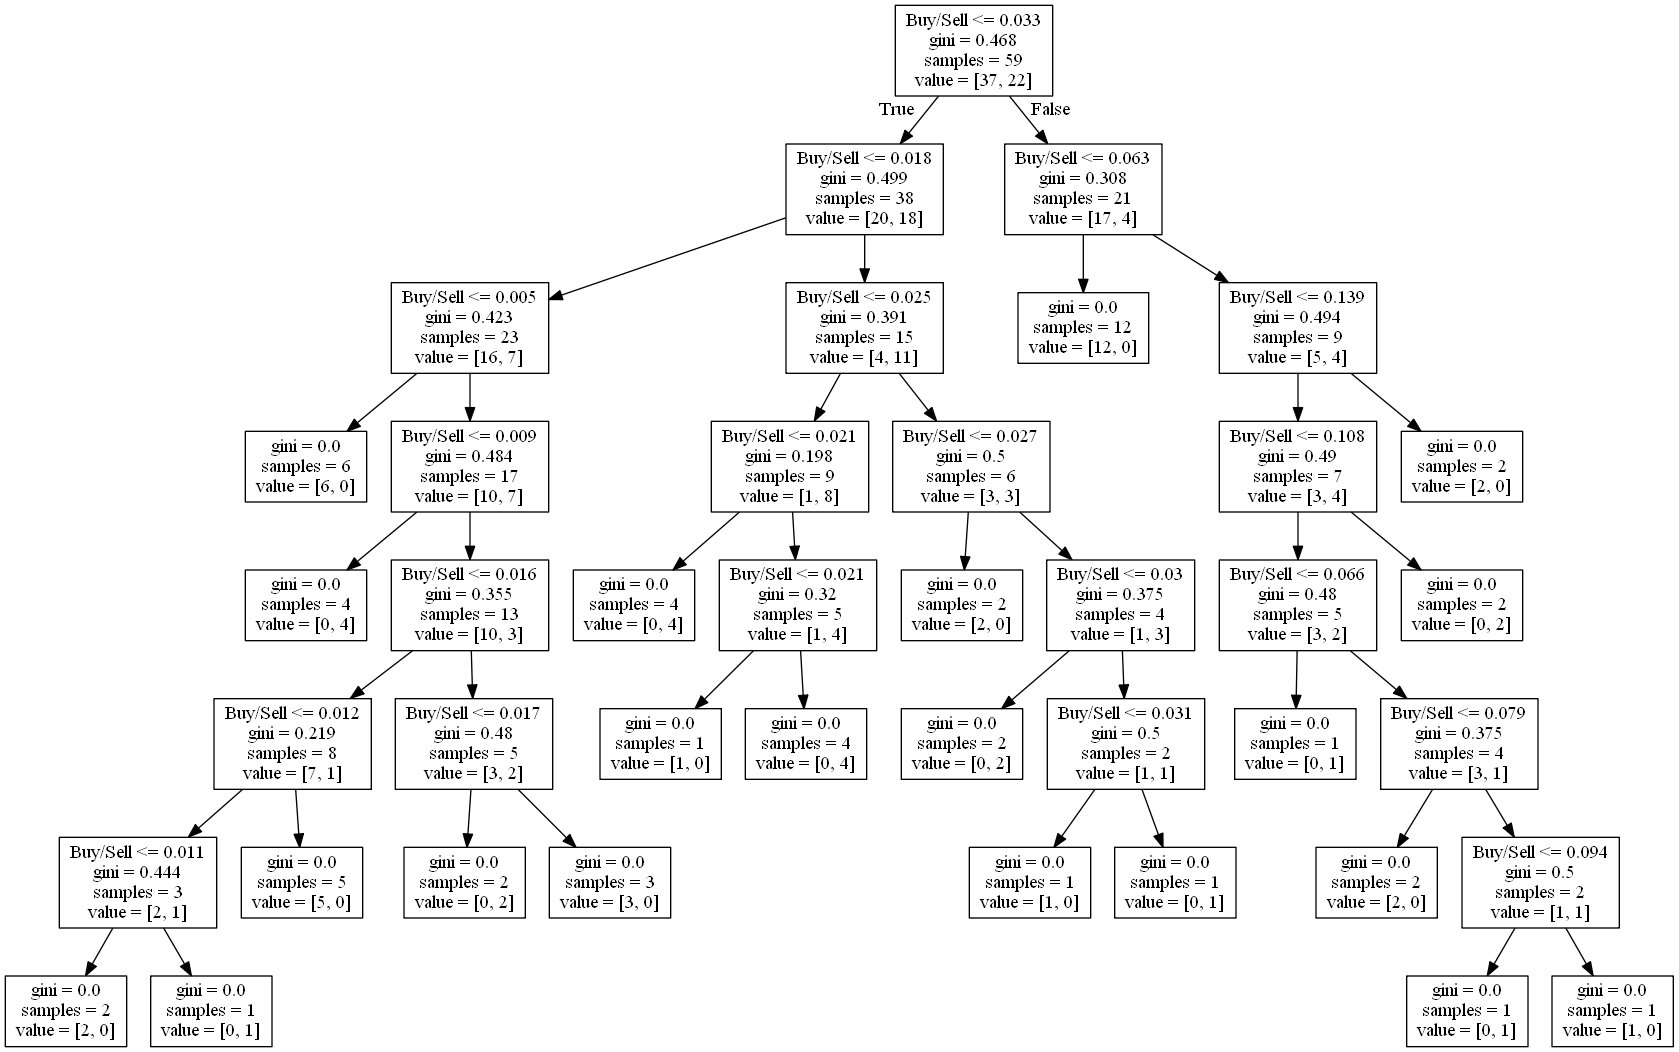

In [23]:
features = ['Buy/Sell']

# import pydotplus
# from sklearn.externals.six import StringIO  
# from IPython.display import Image
dot_data = StringIO()  
tree.export_graphviz(dtc, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

#### Accuracy after cross validation

In [24]:
dtc_cv = cross_val_score(dtc, x_train, y_train, cv=10) 
print(dtc_cv.mean())

0.709523809524


### Random Forest
Accuracy from running only 20% Testing data against 80% Training data. Apparenlty same overfitting problem as with the Decision Tree above. Probably due to the limited amount of data!

In [25]:
# from sklearn.ensemble import RandomForestClassifier 

forest_reg = RandomForestClassifier(random_state=42)
forest_reg.fit(x_train, y_train)
forest_reg.score(x_test, y_test)

0.73333333333333328

#### Accuracy after cross validation

In [26]:
forest_reg_cv = cross_val_score(forest_reg, x_train, y_train, cv=10) 
print(forest_reg_cv.mean())  

0.712857142857


## Results Summary

In [27]:
print("KNN: \t\t\t", neigh_cv.mean())
print("Logistic Regression: \t", logreg_cv.mean())
print("SVM linear: \t\t", svm_linear_cv.mean())
print("Naive Bayes: \t\t", mnb_cv.mean())
print("Decision Tree: \t\t", dtc_cv.mean())
print("Random Forest: \t\t", forest_reg_cv.mean())

KNN: 			 0.575238095238
Logistic Regression: 	 0.627619047619
SVM linear: 		 0.627619047619
Naive Bayes: 		 0.627619047619
Decision Tree: 		 0.709523809524
Random Forest: 		 0.712857142857


In [28]:
results = []
cv = [neigh_cv.mean(), logreg_cv.mean(), svm_linear_cv.mean(),mnb_cv.mean(),dtc_cv.mean(), forest_reg_cv.mean()]
results.append(cv)

In [29]:
results = {'0': ['KNN', 'LogReg', 'SVM linear', 'Naive Bayes', 'Decision Tree', 'Random Forest'],
          '1':[neigh_cv.mean(), logreg_cv.mean(), svm_linear_cv.mean(), mnb_cv.mean(),dtc_cv.mean(),forest_reg_cv.mean()]}

In [30]:
summary = pd.DataFrame.from_dict(results)
summary = summary.transpose()
summary = summary.rename(index = {'0':'Model', '1':'AAL'}) # Update cashtag!

In [31]:
summary

,0,1,2,3,4,5
Model,KNN,LogReg,SVM linear,Naive Bayes,Decision Tree,Random Forest
AAL,0.575238,0.627619,0.627619,0.627619,0.709524,0.712857


### Save the result from each classifier for this cashtag  in an excel
The results are used for creating an overall summary for each cashtag and classifier.

In [32]:
# import xlsxwriter
# import os

writer_df = pd.ExcelWriter('summary.xlsx', engine='xlsxwriter')
summary.to_excel(writer_df)
writer_df.save()

os.rename('summary.xlsx', 'AAL_summary.xlsx') # Update cashtag!